# Combined User Purchase Journeys Analysis

This notebook focuses on visualizing multiple user journeys in a single plot to enable easier comparison between different purchase patterns. It builds on the analysis from the `purchase_journey_analysis.ipynb` and `specific_user_journey.ipynb` notebooks.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from matplotlib.gridspec import GridSpec

# Load the same dataset as in the original notebooks
df = pd.read_csv('analytics.csv')

# Set the same colors as in the original notebook for consistency
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']
facecolor = '#F5F5F5'

# Create a custom colormap for user differentiation
user_colors = plt.cm.tab10.colors  # This gives us 10 distinct colors for different users

In [2]:
# Clean the data and filter relevant entries
# Remove entries without user_id or with placeholder user_ids
df_filtered = df[(df['user_id'] != 'none') & (df['user_id'] != 'less-website')].copy()

# Convert timestamp strings to datetime objects
df_filtered['timestamp'] = pd.to_datetime(df_filtered['created_at'], format='ISO8601')

# Define purchase event indicators
purchase_event_types = ['enforce_wait_modal_shown']

# Function to check if an event type indicates a purchase
def is_purchase_event(event_type):
    # Check for exact matches
    if event_type in purchase_event_types:
        return True
    
    # Check for partial matches in case the naming convention varies
    for purchase_type in purchase_event_types:
        if purchase_type.lower() in event_type.lower():
            return True
    
    return False

# Add a column to identify purchase events
df_filtered['is_purchase'] = df_filtered['type'].apply(is_purchase_event)

# Define the other event types we're interested in
df_filtered['is_add_to_cart'] = df_filtered['type'] == 'add-to-cart'
df_filtered['is_checkout'] = df_filtered['type'] == 'checkout'

In [3]:
# Process sessions similar to the original notebook
session_groups = df_filtered.groupby('session_id')

# Extract session start times, end times, duration, and whether each session contains a purchase
session_data = []
for session_id, session_df in session_groups:
    # Skip sessions with invalid or placeholder IDs
    if session_id == 'none' or pd.isna(session_id):
        continue
        
    # Sort session events by timestamp
    session_df = session_df.sort_values('timestamp')
    
    # Get user_id (assuming it's consistent within a session)
    user_id = session_df['user_id'].iloc[0] if not session_df.empty else None
    
    # Get session start and end times
    start_time = session_df['timestamp'].min()
    end_time = session_df['timestamp'].max()
    
    # Calculate session duration in minutes
    duration_minutes = (end_time - start_time).total_seconds() / 60
    
    # Check for each event type - ensuring uniqueness per session by using .any()
    has_add_to_cart = session_df['is_add_to_cart'].any()
    has_checkout = session_df['is_checkout'].any()
    has_purchase = session_df['is_purchase'].any()
    
    # Find timestamps for FIRST occurrence of each event type
    add_to_cart_time = session_df[session_df['is_add_to_cart']]['timestamp'].min() if has_add_to_cart else None
    checkout_time = session_df[session_df['is_checkout']]['timestamp'].min() if has_checkout else None
    purchase_time = session_df[session_df['is_purchase']]['timestamp'].min() if has_purchase else None
    
    # Determine event sequence order based on first occurrences
    event_order = []
    if has_add_to_cart:
        event_order.append(('add_to_cart', add_to_cart_time))
    if has_checkout:
        event_order.append(('checkout', checkout_time))
    if has_purchase:
        event_order.append(('purchase', purchase_time))
    
    # Sort events by timestamp
    event_order.sort(key=lambda x: x[1])
    
    # Extract the ordered sequence of event types
    event_sequence = [event[0] for event in event_order]
    event_sequence_str = ' → '.join(event_sequence) if event_sequence else 'no_events'
    
    # Collect relevant session details
    session_data.append({
        'session_id': session_id,
        'user_id': user_id,
        'start_time': start_time,
        'end_time': end_time,
        'duration_minutes': duration_minutes,
        'has_add_to_cart': has_add_to_cart,
        'has_checkout': has_checkout,
        'has_purchase': has_purchase,
        'event_sequence': event_sequence_str,
        'event_count': len(session_df)
    })

# Create DataFrame from collected session data
sessions_df = pd.DataFrame(session_data)

# Add flow categorization
def categorize_flow(row):
    # Complete flow
    if row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Complete Flow'
    
    # Add to cart then checkout
    elif row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart then Checkout'
    
    # Checkout then purchase
    elif not row['has_add_to_cart'] and row['has_checkout'] and row['has_purchase']:
        return 'Checkout then Purchase'
    
    # Just add to cart
    elif row['has_add_to_cart'] and not row['has_checkout'] and not row['has_purchase']:
        return 'Add-to-Cart'
    
    # Just checkout
    elif not row['has_add_to_cart'] and row['has_checkout'] and not row['has_purchase']:
        return 'Checkout'
    
    # Just purchase (unusual but possible)
    elif not row['has_add_to_cart'] and not row['has_checkout'] and row['has_purchase']:
        return 'Direct Purchase'
    
    # Just looking
    else:
        return 'Just Looking'

# Apply the flow categorization
sessions_df['flow_category'] = sessions_df.apply(categorize_flow, axis=1)

# Add the simpler categorization as well
def categorize_session(row):
    if not row['has_purchase']:
        return 'Just Looking'
    elif row['duration_minutes'] >= 20:
        return 'Looking Then Purchasing'
    else:
        return 'Quick Purchase'

sessions_df['category'] = sessions_df.apply(categorize_session, axis=1)

# Show basic statistics
print(f"Total sessions: {len(sessions_df)}")
print(f"Sessions with purchases: {sessions_df['has_purchase'].sum()}")
print(f"Unique users: {sessions_df['user_id'].nunique()}")
users_with_purchases = sessions_df[sessions_df['has_purchase']]['user_id'].nunique()
print(f"Users with at least one purchase: {users_with_purchases}")
print(f"Percentage of users who made purchases: {users_with_purchases / sessions_df['user_id'].nunique() * 100:.2f}%")

Total sessions: 137
Sessions with purchases: 10
Unique users: 36
Users with at least one purchase: 7
Percentage of users who made purchases: 19.44%


In [4]:
# Identify users who made at least one purchase
purchasing_users = sessions_df[sessions_df['has_purchase']]['user_id'].unique()
print(f"Number of users who made at least one purchase: {len(purchasing_users)}")

# For each purchasing user, get all their sessions and sort by time
purchasing_user_sessions = sessions_df[sessions_df['user_id'].isin(purchasing_users)].copy()

# For each user, find their first purchase session
first_purchase_sessions = []
journey_to_purchase_data = []

for user_id in purchasing_users:
    # Get all sessions for this user
    user_sessions = purchasing_user_sessions[purchasing_user_sessions['user_id'] == user_id].sort_values('start_time')
    
    # Find the first purchase session for this user
    first_purchase_idx = user_sessions['has_purchase'].idxmax() if user_sessions['has_purchase'].any() else None
    
    if first_purchase_idx is not None:
        first_purchase_session = user_sessions.loc[first_purchase_idx]
        first_purchase_sessions.append(first_purchase_session)
        
        # Get all sessions before the first purchase
        pre_purchase_sessions = user_sessions[user_sessions['start_time'] < first_purchase_session['start_time']]
        
        # Add journey information
        journey_to_purchase_data.append({
            'user_id': user_id,
            'total_sessions_before_purchase': len(pre_purchase_sessions),
            'days_to_first_purchase': (first_purchase_session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24) if len(user_sessions) > 1 else 0,
            'first_purchase_session_id': first_purchase_session['session_id'],
            'first_purchase_category': first_purchase_session['category'],
            'first_purchase_flow': first_purchase_session['flow_category'],
            'pre_purchase_session_categories': pre_purchase_sessions['category'].tolist() if not pre_purchase_sessions.empty else [],
            'pre_purchase_flow_categories': pre_purchase_sessions['flow_category'].tolist() if not pre_purchase_sessions.empty else [],
            'pre_purchase_just_looking_count': sum(1 for cat in pre_purchase_sessions['category'] if cat == 'Just Looking'),
            'pre_purchase_add_to_cart_count': sum(1 for flow in pre_purchase_sessions['flow_category'] if 'Add-to-Cart' in flow),
            'pre_purchase_checkout_count': sum(1 for flow in pre_purchase_sessions['flow_category'] if 'Checkout' in flow)
        })

# Create DataFrame for journey analysis
journey_df = pd.DataFrame(journey_to_purchase_data)

# Show some statistics
print(f"Number of users with journey data: {len(journey_df)}")
print(f"Average sessions before first purchase: {journey_df['total_sessions_before_purchase'].mean():.2f}")
print(f"Median sessions before first purchase: {journey_df['total_sessions_before_purchase'].median():.2f}")
print(f"Average days to first purchase: {journey_df['days_to_first_purchase'].mean():.2f}")
print(f"Median days to first purchase: {journey_df['days_to_first_purchase'].median():.2f}")

Number of users who made at least one purchase: 7
Number of users with journey data: 7
Average sessions before first purchase: 1.14
Median sessions before first purchase: 1.00
Average days to first purchase: 1.88
Median days to first purchase: 0.03


## Select Users for Combined Journey Visualization

Let's select a few users with different journey patterns to compare in a single visualization:
1. A user with many sessions before purchase
2. A user with a medium number of sessions before purchase
3. A user who purchased quickly with few sessions
4. A user with very short sessions

In [5]:
# Find users with different journey patterns
# Get users with most sessions before purchase
users_many_sessions = journey_df[journey_df['total_sessions_before_purchase'] >= 3].sort_values(
    by='total_sessions_before_purchase', ascending=False).head(3)

# Get users with medium number of sessions (2-3)
users_medium_sessions = journey_df[
    (journey_df['total_sessions_before_purchase'] >= 1) & 
    (journey_df['total_sessions_before_purchase'] <= 2)
].sample(min(3, len(journey_df[(journey_df['total_sessions_before_purchase'] >= 1) & 
                               (journey_df['total_sessions_before_purchase'] <= 2)])))

# Get users who purchased quickly (direct purchase or very short journey)
users_quick_purchase = journey_df[
    (journey_df['total_sessions_before_purchase'] == 0) | 
    ((journey_df['total_sessions_before_purchase'] == 1) & (journey_df['days_to_first_purchase'] < 1))
].sample(min(3, len(journey_df[(journey_df['total_sessions_before_purchase'] == 0) | 
                              ((journey_df['total_sessions_before_purchase'] == 1) & 
                               (journey_df['days_to_first_purchase'] < 1))])))

# Combine all selected users
selected_users = pd.concat([users_many_sessions, users_medium_sessions, users_quick_purchase])
selected_user_ids = selected_users['user_id'].unique()

print(f"Selected {len(selected_user_ids)} users with diverse journey patterns for combined visualization")
for i, user_id in enumerate(selected_user_ids):
    user_journey = journey_df[journey_df['user_id'] == user_id].iloc[0]
    print(f"{i+1}. User {user_id}: {user_journey['total_sessions_before_purchase']} sessions before purchase, {user_journey['days_to_first_purchase']:.2f} days to purchase")

Selected 6 users with diverse journey patterns for combined visualization
1. User 1850b7a3-5cad-4d7b-a4a0-3c8dd534437d: 3 sessions before purchase, 1.49 days to purchase
2. User 801d88ba-f931-47c2-a5a1-ef006e2644ad: 1 sessions before purchase, 0.03 days to purchase
3. User e2eb1291-5fec-45e6-bded-3018f0d67d66: 2 sessions before purchase, 7.59 days to purchase
4. User a8813899-eb7b-49f9-9e97-7f91f995e944: 2 sessions before purchase, 4.05 days to purchase
5. User fc85fe0b-2211-41c8-8a71-159caa472e03: 0 sessions before purchase, 0.00 days to purchase
6. User 42e523b9-71a9-4304-938a-547e433bff6c: 0 sessions before purchase, 0.00 days to purchase


In [6]:
# Function to prepare timeline data for a user
def prepare_user_timeline(user_id):
    user_sessions = sessions_df[sessions_df['user_id'] == user_id].sort_values('start_time')
    
    # Find the first purchase session
    purchase_sessions = user_sessions[user_sessions['has_purchase']]
    if purchase_sessions.empty:
        return None
        
    first_purchase_session = purchase_sessions.iloc[0]
    purchase_time = first_purchase_session['start_time']
    
    # Prepare timeline data
    timeline_data = []
    for _, session in user_sessions.iterrows():
        # Calculate time from first session
        time_from_first = (session['start_time'] - user_sessions['start_time'].min()).total_seconds() / (60*60*24)
        
        # Flag for very short sessions (less than 10 seconds)
        is_very_short = session['duration_minutes'] < (10 / 60)
        
        # Determine session type color and marker
        if session['has_purchase']:
            color = colors[4]  # Purchase event
            marker = 'o'
            size = 150
            zorder = 10
        elif 'Add-to-Cart' in session['flow_category'] and 'Checkout' in session['flow_category']:
            color = colors[3]  # Add to cart + checkout
            marker = 's'
            size = 120
            zorder = 8
        elif 'Add-to-Cart' in session['flow_category']:
            color = colors[2]  # Add to cart
            marker = 'D'
            size = 100
            zorder = 6
        elif 'Checkout' in session['flow_category']:
            color = colors[1]  # Checkout
            marker = '^'
            size = 100
            zorder = 7
        else:
            color = colors[0]  # Just looking
            marker = 'x'
            size = 80
            zorder = 5
            
        timeline_data.append({
            'session_id': session['session_id'],
            'time_days': time_from_first,
            'duration_minutes': session['duration_minutes'],
            'flow_category': session['flow_category'],
            'has_purchase': session['has_purchase'],
            'color': color,
            'marker': marker,
            'size': size,
            'zorder': zorder,
            'is_very_short': is_very_short
        })
    
    # Adjust x-coordinates for better spacing when events are too close
    timeline_data.sort(key=lambda x: x['time_days'])
    
    # Define minimum gap (in days) that we want between events
    min_gap = 0.3  # Smaller minimum gap for combined visualization
    
    # Adjust positions
    for j in range(1, len(timeline_data)):
        actual_gap = timeline_data[j]['time_days'] - timeline_data[j-1]['time_days']
        
        # If events are too close together
        if 0 < actual_gap < min_gap:
            # Shift current and all following events to maintain minimum gap
            shift = min_gap - actual_gap
            for k in range(j, len(timeline_data)):
                timeline_data[k]['time_days'] += shift
    
    return {
        'user_id': user_id,
        'timeline_data': timeline_data,
        'purchase_time': purchase_time,
        'original_days_to_purchase': (purchase_time - user_sessions['start_time'].min()).total_seconds() / (60*60*24),
        'sessions_before_purchase': len(user_sessions[user_sessions['start_time'] < purchase_time])
    }

In [7]:
# Prepare timeline data for all selected users
user_timelines = []
for user_id in selected_user_ids:
    timeline = prepare_user_timeline(user_id)
    if timeline:
        user_timelines.append(timeline)

print(f"Prepared timeline data for {len(user_timelines)} users")

Prepared timeline data for 6 users


## Combined User Journey Visualization

Now let's create a visualization that shows multiple user journeys in a single plot, allowing for easy comparison between different purchase patterns.

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_34856/3187476087.py:35: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


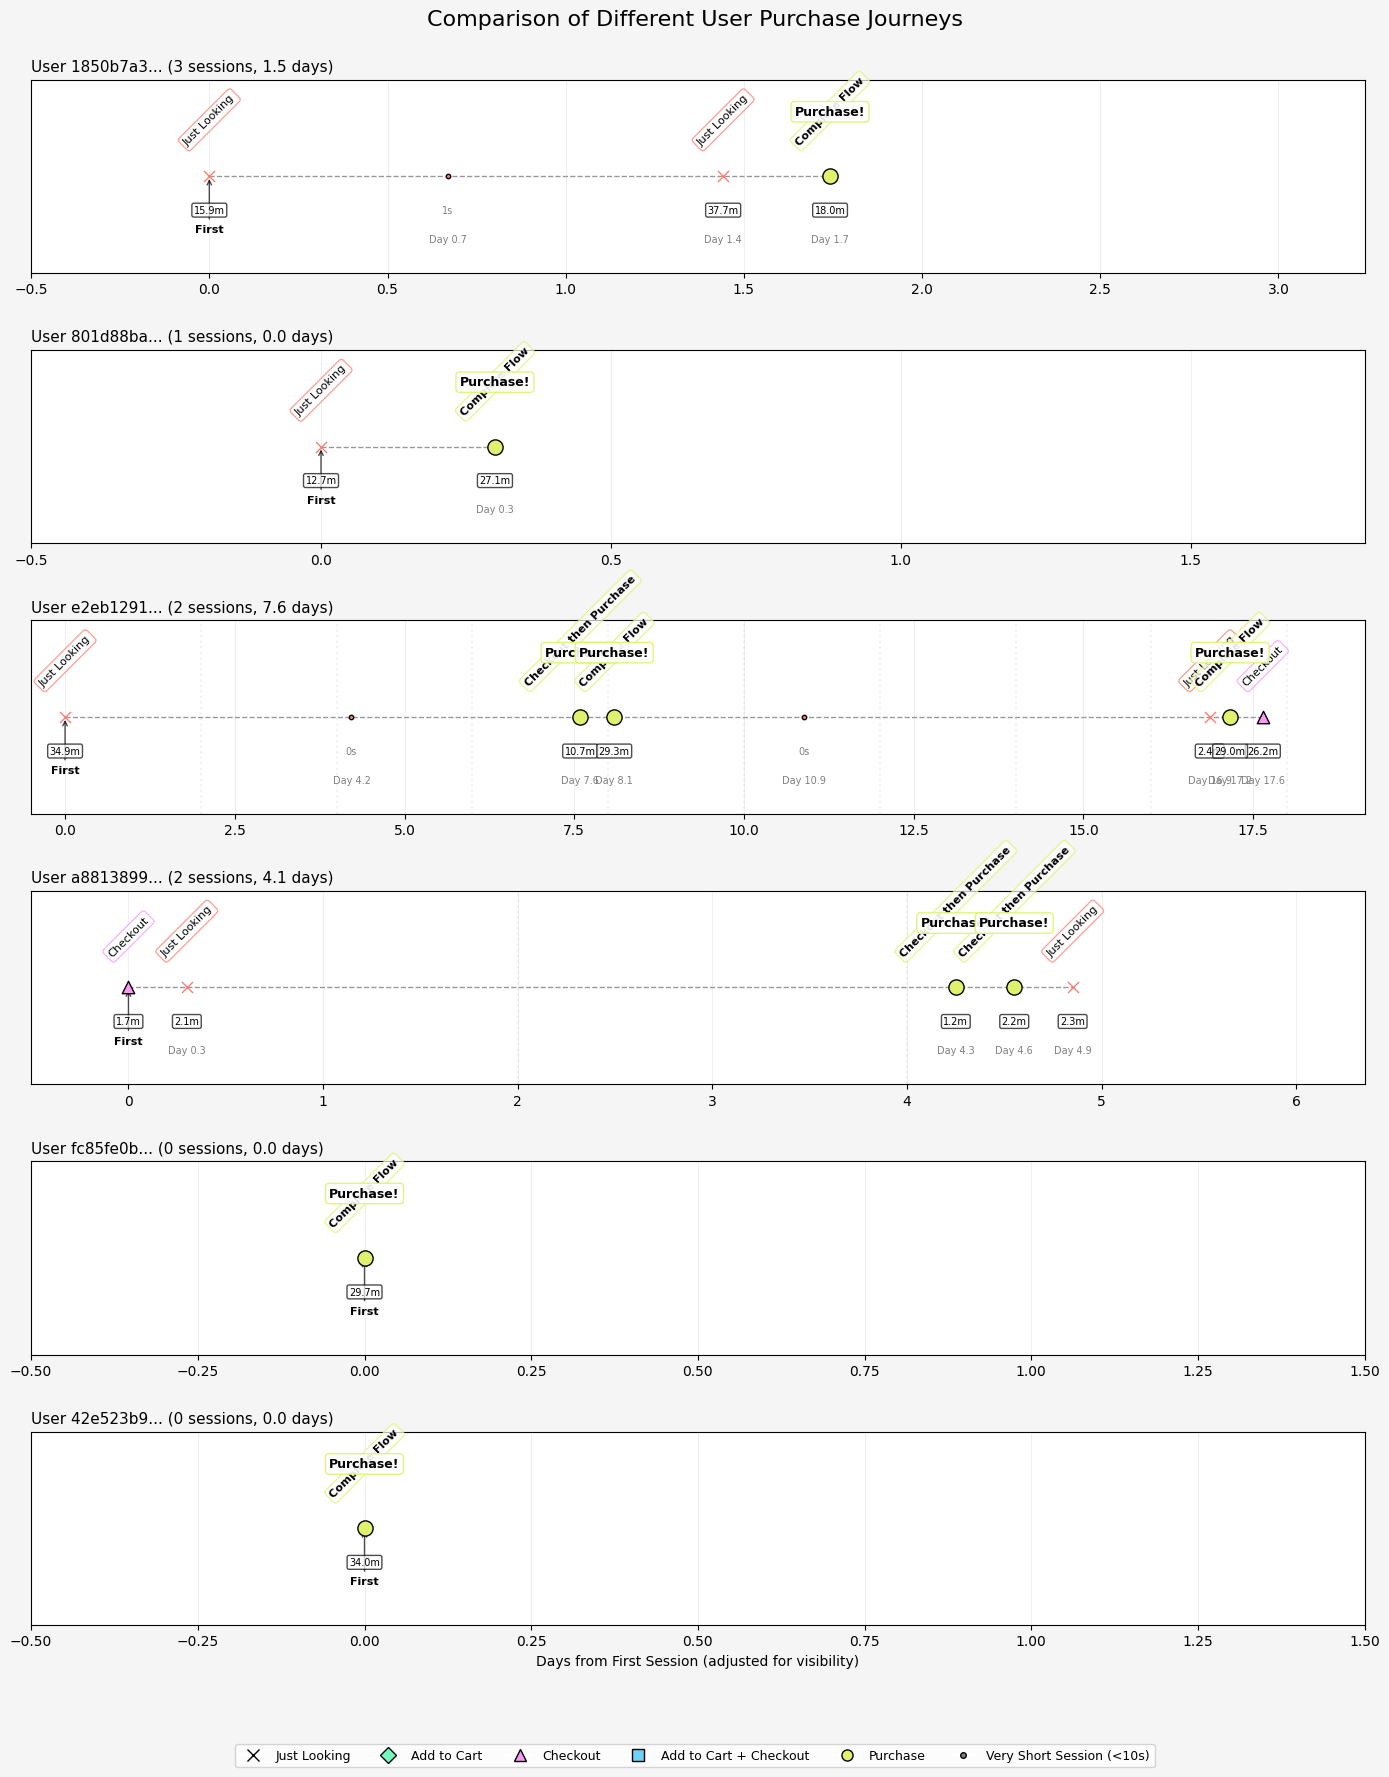

In [ ]:
# Create a combined visualization of user journeys
def plot_combined_user_journeys(user_timelines, max_users=6):
    # Limit to max_users for better readability
    if len(user_timelines) > max_users:
        user_timelines = user_timelines[:max_users]
    
    num_users = len(user_timelines)
    
    # Set up the plot with a larger figure
    plt.figure(figsize=(14, 3 * num_users), facecolor=facecolor)
    
    # Create a separate subplot for each user
    for i, user_timeline in enumerate(user_timelines):
        user_id = user_timeline['user_id']
        timeline_data = user_timeline['timeline_data']
        
        # Create a subplot for this user
        plt.subplot(num_users, 1, i+1)
        
        # Plot each session as a point
        for session in timeline_data:
            # Use smaller dot for very short sessions
            if session['is_very_short']:
                plt.scatter(
                    session['time_days'], 
                    0.5,  # Fixed y-position for timeline
                    color=session['color'],
                    s=40,  # Smaller size for very short sessions
                    marker='.',  # Dot marker for very short sessions
                    zorder=session['zorder'],
                    edgecolors='black',
                    linewidth=1
                )
            else:
                plt.scatter(
                    session['time_days'], 
                    0.5,  # Fixed y-position for timeline
                    color=session['color'],
                    s=session['size'] * 0.8,  # Slightly smaller than in individual plots
                    marker=session['marker'],
                    zorder=session['zorder'],
                    edgecolors='black',
                    linewidth=1
                )
            
            # Add flow category label above point with more vertical space
            # Only add text labels for sessions that aren't very short to avoid clutter
            if not session['is_very_short']:
                plt.text(
                    session['time_days'],
                    0.65,  # Increased vertical position
                    session['flow_category'],
                    rotation=45,
                    ha='center',
                    va='bottom',
                    fontsize=8,  # Smaller font for combined view
                    fontweight='bold' if session['has_purchase'] else 'normal',
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor=session['color'], boxstyle='round,pad=0.3'),
                    zorder=session['zorder']
                )
            
            # For purchase sessions, add a separate "Purchase!" label
            if session['has_purchase']:
                plt.text(
                    session['time_days'],
                    0.8,  # Higher position to avoid overlap
                    "Purchase!",
                    rotation=0,  # No rotation for better visibility
                    ha='center',
                    va='bottom',
                    fontsize=9,  # Slightly larger font for emphasis
                    fontweight='bold',
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.9, edgecolor=colors[4], boxstyle='round,pad=0.3'),
                    zorder=session['zorder'] + 1  # Higher zorder to stand out
                )
            
            # Add duration label below point (only for non-very-short sessions)
            if not session['is_very_short']:
                plt.text(
                    session['time_days'],
                    0.35,  # Lower position for better spacing
                    f"{session['duration_minutes']:.1f}m",  # Shorter label
                    ha='center',
                    va='top',
                    fontsize=7,
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'),
                    zorder=session['zorder']
                )
            # For very short sessions, add a small duration label
            else:
                seconds = session['duration_minutes'] * 60
                plt.text(
                    session['time_days'],
                    0.35,  # Lower position
                    f"{seconds:.0f}s",  # Show seconds instead of minutes
                    ha='center',
                    va='top',
                    fontsize=7,
                    color='gray',
                    zorder=session['zorder'] - 1
                )
            
            # Add time from first session as a more subtle label
            if session['time_days'] > 0.1:  # Skip for first session
                plt.text(
                    session['time_days'],
                    0.2,  # Lower position
                    f"Day {session['time_days']:.1f}",
                    ha='center',
                    va='top',
                    fontsize=7,
                    color='gray',
                    zorder=session['zorder'] - 1
                )
        
        # Connect points with lines
        times = [session['time_days'] for session in timeline_data]
        plt.plot(times, [0.5] * len(times), 'k--', alpha=0.4, zorder=1, linewidth=1)
        
        # Add clear markers for timeline scale
        if max(times) > 3:  # Only add markers if timeline is long enough
            day_markers = list(range(0, int(max(times)) + 2, 2))  # Every 2 days
            for day in day_markers:
                if day > 0:  # Skip day 0
                    plt.axvline(x=day, color='lightgray', linestyle=':', alpha=0.3, zorder=0)
        
        # Add first session annotation
        if len(timeline_data) > 0:
            plt.annotate('First', 
                       (timeline_data[0]['time_days'], 0.5),
                       xytext=(timeline_data[0]['time_days'], 0.25),
                       arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
                       ha='center', va='top', fontsize=8, weight='bold')
        
        # Set up this subplot
        plt.title(f'User {chr(65+i)} ({user_timeline["sessions_before_purchase"]} sessions, {user_timeline["original_days_to_purchase"]:.1f} days)', 
                 fontsize=11, loc='left')
        plt.yticks([])
        plt.grid(True, axis='x', alpha=0.2)
        
        # Add padding to x-axis for better appearance
        plt.xlim(left=-0.5, right=max(times) + 1.5 if times else 1)
        plt.ylim(0, 1)
        
        # Only add x-axis label to the bottom plot
        if i == num_users - 1:
            plt.xlabel('Days from First Session (adjusted for visibility)', fontsize=10)
    
    # Add a common legend at the bottom
    legend_elements = [
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor=colors[0], markersize=8, label='Just Looking', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=8, label='Add to Cart', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[1], markersize=8, label='Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=8, label='Add to Cart + Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=8, label='Purchase', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='gray', markersize=8, label='Very Short Session (<10s)', markeredgecolor='black')
    ]
    
    plt.figlegend(handles=legend_elements, loc='lower center', ncol=6, frameon=True, 
                 bbox_to_anchor=(0.5, 0), fontsize=9)
    
    plt.suptitle('Comparison of Different User Purchase Journeys', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Make room for the common legend
    plt.subplots_adjust(hspace=0.4)  # Add some space between subplots
    
    plt.show()

# Plot the combined visualization
plot_combined_user_journeys(user_timelines)

## Alternate Visualization: Users on a Single Timeline

Let's create an alternative visualization with all users displayed on a single timeline, using different colors for each user.

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_34856/1623002460.py:57: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


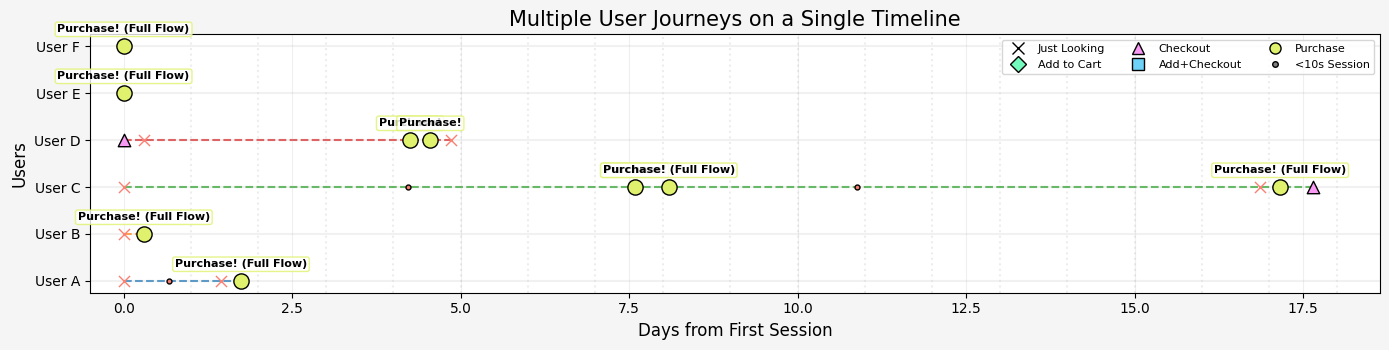

In [25]:
# Create a single plot with all user journeys
def plot_unified_user_journeys(user_timelines, max_users=6):

    # Limit to max_users for readability
    if len(user_timelines) > max_users:
        user_timelines = user_timelines[:max_users]
    
    num_users = len(user_timelines)
    
    # Set up the plot
    plt.figure(figsize=(14, 4), facecolor=facecolor)
    
    # Calculate vertical spacing for each user
    y_positions = np.linspace(0.2, 0.8, num_users)
    user_y_map = {user_timeline['user_id']: y_pos for user_timeline, y_pos in zip(user_timelines, y_positions)}
    
    # Process all users
    all_times = []
    
    # First pass: plot the connecting lines for each user
    for i, user_timeline in enumerate(user_timelines):
        user_id = user_timeline['user_id']
        timeline_data = user_timeline['timeline_data']
        y_pos = user_y_map[user_id]
        
        # Extract times for this user
        times = [session['time_days'] for session in timeline_data]
        all_times.extend(times)
        
        # Connect points with lines
        plt.plot(times, [y_pos] * len(times), '--', color=user_colors[i % len(user_colors)], 
                alpha=0.7, zorder=1, linewidth=1.5, label=f"User {chr(65+i)}")
    
    # Second pass: plot the individual session markers
    for i, user_timeline in enumerate(user_timelines):
        user_id = user_timeline['user_id']
        timeline_data = user_timeline['timeline_data']
        y_pos = user_y_map[user_id]
        
        # Plot each session as a point
        for session in timeline_data:
            # Determine the marker
            if session['has_purchase']:
                marker = 'o'  # Purchase
                size = 120
                zorder = 10
            elif session['is_very_short']:
                marker = '.'  # Very short
                size = 50
                zorder = 5
            else:
                marker = session['marker']
                size = session['size'] * 0.8
                zorder = session['zorder']
            
            # Plot the marker
            plt.scatter(
                session['time_days'], 
                y_pos,
                color=session['color'],
                s=size,
                marker=marker,
                zorder=zorder,
                edgecolors='black',
                linewidth=1
            )
            
            # Add short label for purchase sessions
            if session['has_purchase']:
                purchase_label = "Purchase!"
                # Check if this was a complete flow (add to cart + checkout + purchase)
                if 'Complete Flow' in session['flow_category']:
                    purchase_label = "Purchase! (Full Flow)"
                
                plt.text(
                    session['time_days'],
                    y_pos + 0.03,
                    purchase_label,
                    rotation=0,
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    fontweight='bold',
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor=colors[4], boxstyle='round,pad=0.2'),
                    zorder=zorder + 1
                )
    
    # Add day markers on the x-axis
    max_time = max(all_times) if all_times else 10
    day_markers = list(range(0, int(max_time) + 2))
    for day in day_markers:
        if day > 0:  # Skip day 0
            plt.axvline(x=day, color='lightgray', linestyle=':', alpha=0.4, zorder=0)
    
    # Add grid lines for each user's position
    for y_pos in y_positions:
        plt.axhline(y=y_pos, color='lightgray', linestyle='-', alpha=0.3, zorder=0)
    
    # Set up the plot
    plt.title('Multiple User Journeys on a Single Timeline', fontsize=15)
    plt.xlabel('Days from First Session', fontsize=12)
    plt.ylabel('Users', fontsize=12)
    plt.yticks(y_positions, [f"User {chr(65+i)}" for i in range(len(user_timelines))])
    plt.grid(True, axis='x', alpha=0.2)
    
    # Add padding to x-axis
    plt.xlim(left=-0.5, right=max_time + 1)
    
    # Add a legend for the session types - more compact with increased columns
    legend_elements = [
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor=colors[0], markersize=8, label='Just Looking', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=8, label='Add to Cart', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[1], markersize=8, label='Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=8, label='Add+Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=8, label='Purchase', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='gray', markersize=8, label='<10s Session', markeredgecolor='black')
    ]
    
    plt.legend(handles=legend_elements, loc='upper right', ncol=3, frameon=True, fontsize=8)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Plot the unified visualization
plot_unified_user_journeys(user_timelines)

## Side-by-Side Journey Pattern Comparison

Finally, let's create a grid visualization to compare user journey patterns side by side, focusing on shorter timelines for better comparison.

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_34856/4211923232.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


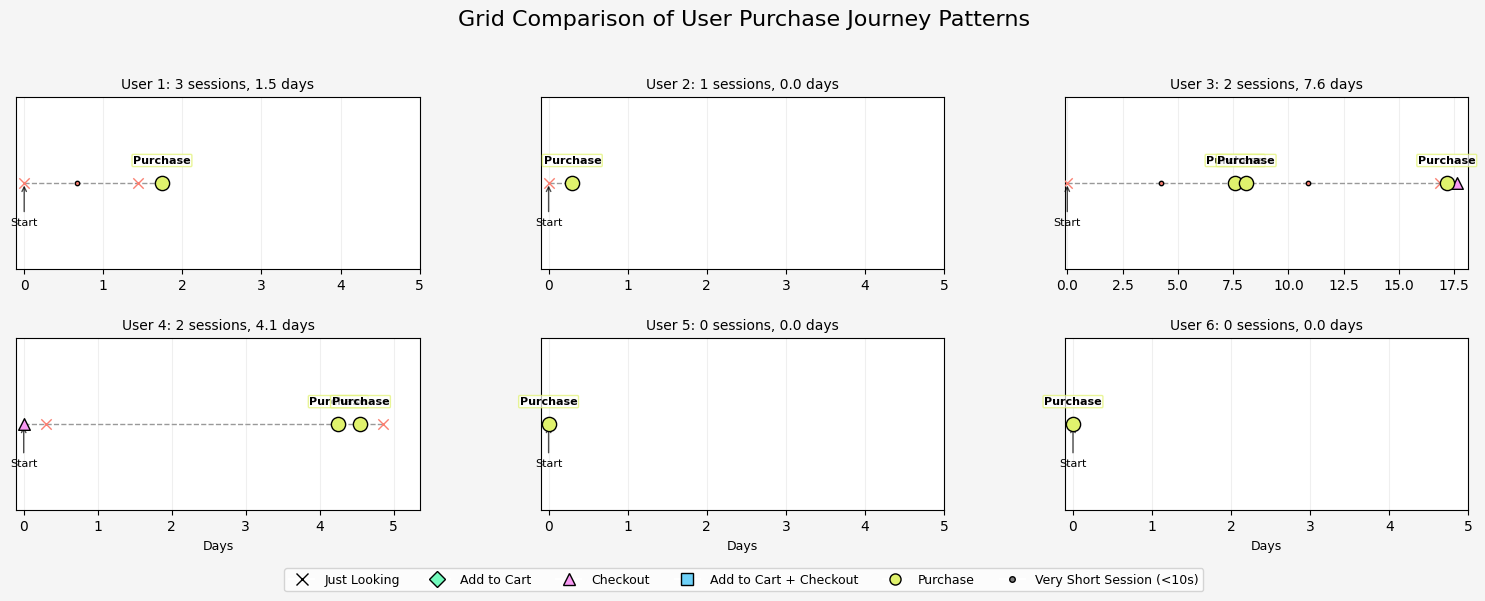

In [ ]:
# Create a grid of user journeys for easier comparison
def plot_journey_grid(user_timelines, max_users=9, grid_size=None):
    # Limit to max_users
    if len(user_timelines) > max_users:
        user_timelines = user_timelines[:max_users]
    
    num_users = len(user_timelines)
    
    # Determine grid dimensions
    if grid_size:
        rows, cols = grid_size
    else:
        cols = min(3, num_users)
        rows = (num_users + cols - 1) // cols  # Ceiling division
    
    # Set up the figure
    fig = plt.figure(figsize=(5 * cols, 3 * rows), facecolor=facecolor)
    
    # Process each user
    for i, user_timeline in enumerate(user_timelines):
        if i >= rows * cols:
            break
            
        user_id = user_timeline['user_id']
        timeline_data = user_timeline['timeline_data']
        
        # Create subplot
        ax = plt.subplot(rows, cols, i + 1)
        
        # Plot each session as a point
        for session in timeline_data:
            # Use smaller dot for very short sessions
            if session['is_very_short']:
                ax.scatter(
                    session['time_days'], 
                    0.5,
                    color=session['color'],
                    s=40,
                    marker='.',
                    zorder=session['zorder'],
                    edgecolors='black',
                    linewidth=1
                )
            else:
                ax.scatter(
                    session['time_days'], 
                    0.5,
                    color=session['color'],
                    s=session['size'] * 0.7,
                    marker=session['marker'],
                    zorder=session['zorder'],
                    edgecolors='black',
                    linewidth=1
                )
                
            # Add minimal labels
            if session['has_purchase']:
                ax.text(
                    session['time_days'],
                    0.6,
                    "Purchase",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    fontweight='bold',
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor=colors[4], boxstyle='round,pad=0.1'),
                    zorder=session['zorder'] + 1
                )
        
        # Connect points with lines
        times = [session['time_days'] for session in timeline_data]
        ax.plot(times, [0.5] * len(times), 'k--', alpha=0.4, zorder=1, linewidth=1)
        
        # Set up this subplot
        sessions_count = user_timeline["sessions_before_purchase"]
        days_to_purchase = user_timeline["original_days_to_purchase"]
        
        ax.set_title(f'User {chr(65+i)}: {sessions_count} sessions, {days_to_purchase:.1f} days', fontsize=10)
        ax.set_yticks([])
        ax.grid(True, axis='x', alpha=0.2)
        
        # Add x-axis label with consistent scale
        max_days = max(times) if times else 0
        ax.set_xlim(left=-0.1, right=max(5, max_days + 0.5))  # At least 5 days shown for consistency
        ax.set_ylim(0, 1)
        
        if i >= (rows - 1) * cols:  # Only for bottom row
            ax.set_xlabel('Days', fontsize=9)
        
        # Add first session annotation
        if len(timeline_data) > 0:
            ax.annotate('Start', 
                      (timeline_data[0]['time_days'], 0.5),
                      xytext=(timeline_data[0]['time_days'], 0.3),
                      arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
                      ha='center', va='top', fontsize=8)
    
    # Add a common legend at the bottom
    legend_elements = [
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor=colors[0], markersize=8, label='Just Looking', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[2], markersize=8, label='Add to Cart', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[1], markersize=8, label='Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=8, label='Add to Cart + Checkout', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], markersize=8, label='Purchase', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='gray', markersize=8, label='Very Short Session (<10s)', markeredgecolor='black')
    ]
    
    plt.figlegend(handles=legend_elements, loc='lower center', ncol=6, frameon=True, 
                 bbox_to_anchor=(0.5, 0), fontsize=9)
    
    plt.suptitle('Grid Comparison of User Purchase Journey Patterns', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    plt.show()

# Plot the grid visualization
plot_journey_grid(user_timelines)

## Text-Based Journey Comparison

Let's also create a text-based comparison of the user journeys to complement the visualizations.

In [ ]:
# Create a text-based comparison of user journeys
def print_journey_patterns(user_timelines):
    print("## User Journey Pattern Comparison ##\n")
    
    for i, user_timeline in enumerate(user_timelines):
        user_id = user_timeline['user_id']
        timeline_data = user_timeline['timeline_data']
        sessions_count = user_timeline["sessions_before_purchase"]
        days_to_purchase = user_timeline["original_days_to_purchase"]
        
        print(f"User {chr(65+i)}: ({sessions_count} sessions, {days_to_purchase:.1f} days)")
        
        # Create a text representation of the journey
        journey_pattern = []
        for session in timeline_data:
            prefix = "[<10s] " if session['is_very_short'] else ""
            if session['has_purchase']:
                journey_pattern.append(f"{prefix}{session['flow_category']} (Purchase!)")
            else:
                journey_pattern.append(f"{prefix}{session['flow_category']}")
        
        print("Journey: " + " → ".join(journey_pattern))
        print("-" * 80 + "\n")

# Print the text comparison
print_journey_patterns(user_timelines)

## User Journey Pattern Comparison ##

User 1: 1850b7a3... (3 sessions, 1.5 days)
Journey: Just Looking → [<10s] Just Looking → Just Looking → Complete Flow (Purchase!)
--------------------------------------------------------------------------------

User 2: 801d88ba... (1 sessions, 0.0 days)
Journey: Just Looking → Complete Flow (Purchase!)
--------------------------------------------------------------------------------

User 3: e2eb1291... (2 sessions, 7.6 days)
Journey: Just Looking → [<10s] Just Looking → Checkout then Purchase (Purchase!) → Complete Flow (Purchase!) → [<10s] Just Looking → Just Looking → Complete Flow (Purchase!) → Checkout
--------------------------------------------------------------------------------

User 4: a8813899... (2 sessions, 4.1 days)
Journey: Checkout → Just Looking → Checkout then Purchase (Purchase!) → Checkout then Purchase (Purchase!) → Just Looking
--------------------------------------------------------------------------------

User 5: fc85fe0b.

## Journey Pattern Analysis

Based on our combined visualizations of different user journeys, we can identify several distinct purchase patterns:

1. **Direct Purchasers**: Users who make a purchase in their very first session, demonstrating decisive shopping behavior.

2. **Researching Shoppers**: Users with multiple "Just Looking" sessions before eventually making a purchase, suggesting a more deliberate research process.

3. **Cart Abandoners**: Users who add items to cart in early sessions but don't complete the purchase until a later session.

4. **Quick Returners**: Users who visit briefly (very short sessions) multiple times before making a purchase decision.

5. **Complex Journey Shoppers**: Users with a mix of different session types (browsing, adding to cart, checkout) before finally making a purchase.

These different patterns could inform different intervention strategies for the anti-impulsive purchasing extension, with each pattern potentially benefiting from customized approaches.